In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import folium
from geopy.geocoders import Nominatim
import time
import warnings
warnings.filterwarnings('ignore')



In [10]:
# Load dataset
dataset = pd.read_csv('indian_crime_data.csv')  # replace with your file path

# Inspect the data
print(dataset.head())
print(dataset.info())


   Report Number     Date Reported Date of Occurrence Time of Occurrence  \
0              1  02-01-2020 00:00   01-01-2020 00:00   01-01-2020 01:11   
1              2  01-01-2020 19:00   01-01-2020 01:00   01-01-2020 06:26   
2              3  02-01-2020 05:00   01-01-2020 02:00   01-01-2020 14:30   
3              4  01-01-2020 05:00   01-01-2020 03:00   01-01-2020 14:46   
4              5  01-01-2020 21:00   01-01-2020 04:00   01-01-2020 16:51   

        City  Crime Code Crime Description  Victim Age Victim Gender  \
0  Ahmedabad         576    IDENTITY THEFT          16             M   
1    Chennai         128          HOMICIDE          37             M   
2   Ludhiana         271        KIDNAPPING          48             F   
3       Pune         170          BURGLARY          49             F   
4       Pune         421         VANDALISM          30             F   

    Weapon Used   Crime Domain  Police Deployed Case Closed  Date Case Closed  
0  Blunt Object  Violent Crime

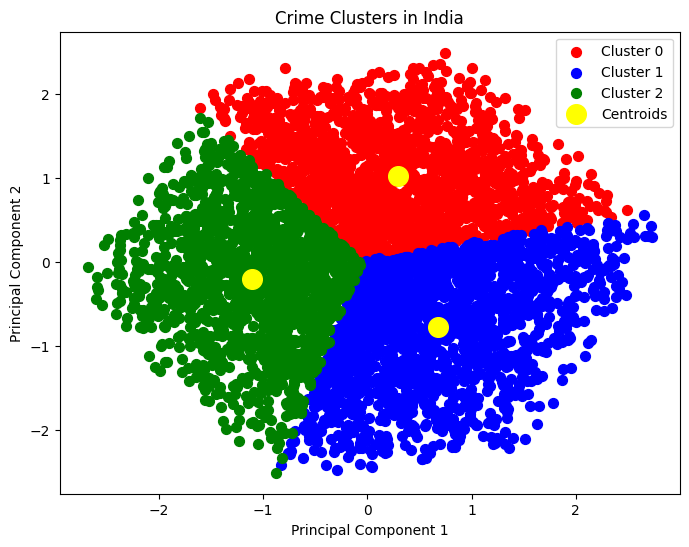

In [11]:
# Use numerical columns for clustering
X1 = dataset[['Crime Code', 'Victim Age', 'Police Deployed']].dropna().values

# Feature scaling
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X1_scaled = sc_x.fit_transform(X1)

# Optional: Sample data if dataset is huge
sample_size = 5000  # adjust based on your RAM
if len(X1_scaled) > sample_size:
    np.random.seed(42)
    idx = np.random.choice(len(X1_scaled), sample_size, replace=False)
    X1_sample = X1_scaled[idx]
else:
    X1_sample = X1_scaled

# Linear PCA for visualization (memory-friendly)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X1_pca = pca.fit_transform(X1_sample)

# KMeans clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X1_pca)

# Plot clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(X1_pca[y_kmeans == 0, 0], X1_pca[y_kmeans == 0, 1], s=50, c='red', label='Cluster 0')
plt.scatter(X1_pca[y_kmeans == 1, 0], X1_pca[y_kmeans == 1, 1], s=50, c='blue', label='Cluster 1')
plt.scatter(X1_pca[y_kmeans == 2, 0], X1_pca[y_kmeans == 2, 1], s=50, c='green', label='Cluster 2')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=200, c='yellow', label='Centroids')
plt.title('Crime Clusters in India')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()



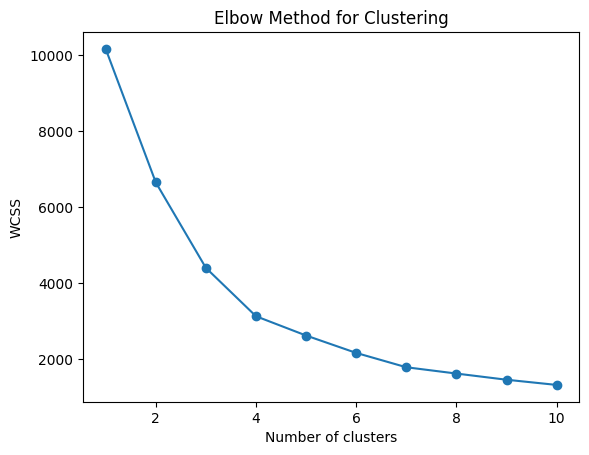

In [12]:
# Elbow method to find optimal clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X1_pca)   # use X1_pca instead of X1_kpca
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()




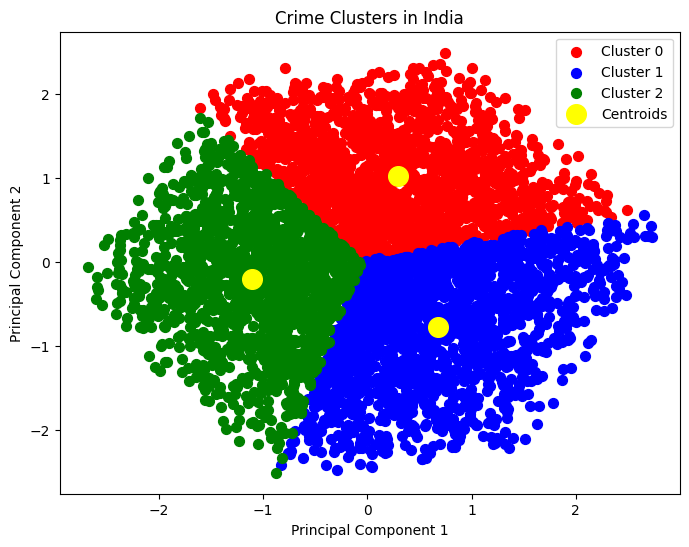

In [13]:
# Fit KMeans with chosen number of clusters
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X1_pca)

plt.figure(figsize=(8,6))
plt.scatter(X1_pca[y_kmeans == 0, 0], X1_pca[y_kmeans == 0, 1], s=50, c='red', label='Cluster 0')
plt.scatter(X1_pca[y_kmeans == 1, 0], X1_pca[y_kmeans == 1, 1], s=50, c='blue', label='Cluster 1')
plt.scatter(X1_pca[y_kmeans == 2, 0], X1_pca[y_kmeans == 2, 1], s=50, c='green', label='Cluster 2')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=200, c='yellow', label='Centroids')
plt.title('Crime Clusters in India')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()



In [14]:
# Encode City and Crime Description
le_city = LabelEncoder()
le_crime = LabelEncoder()
dataset['City_Code'] = le_city.fit_transform(dataset['City'])
dataset['Crime_Label'] = le_crime.fit_transform(dataset['Crime Description'])

# Features and target for Random Forest
X = dataset[['City_Code', 'Police Deployed']].values
Y = dataset['Crime_Label'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



In [15]:
# Random Forest classifier
classifier = RandomForestClassifier(n_estimators=500, criterion='entropy', random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)


Confusion Matrix:
 [[21 19 18 15 15 23 20 29 28 27 24 28 14 27 26 18 30 11 23 30 20]
 [22 22 26 25 16 34 26 25 20 19 19 25 19 19 18 32 24 13 28 30 21]
 [25 20 18 17 28 25 29 29 36 19 23 27 13 23 25 39 29 14 24 34 21]
 [16 25 13 23 15 25 15 14 43 27 18 24 12 20 24 38 21 18 30 32 23]
 [28 24 22 19 17 28 32 25 34 26 22 23 14 11 19 26 32 16 21 23 29]
 [25 30 28 23 21 35 21 20 28 30 24 27 20 27 16 27 31 23 24 24 15]
 [14 21 19 22 17 26 15 21 24 22 23 28 11 23 19 35 31 15 29 30 13]
 [19 15 21 18 20 28 26 29 28 26 27 27 21 18 11 33 24 19 31 25 15]
 [23 13 16 17 22 31 25 20 26 25 15 21 17 18 24 27 28 20 22 25 13]
 [26 21 13 16 24 24 24 24 24 27 27 23 20 21 22 25 36 12 23 27 27]
 [14 23 27 19 14 27 12 16 29 30 26 19 21 16 18 16 25 21 36 21 24]
 [26 22 17 16 14 20 26 26 30 28 25 21 20 19 17 27 25 13 31 33 21]
 [23 22 25 16 12 27 22 22 28 28 25 19 15 13 22 25 32 11 22 32 14]
 [24 14 19  8 22 16 19 24 25 20 35 23 22 16 13 31 30 20 19 36 26]
 [23 26 18 26 20 25 29 17 29 28 17 20 21 18 25 31 24 20 2

In [16]:

# 1. Geocode each city only once
unique_cities = dataset['City'].unique()
city_coords = {}
geolocator = Nominatim(user_agent='crime_map')

for city in unique_cities:
    try:
        location = geolocator.geocode(city)
        if location:
            city_coords[city] = (location.latitude, location.longitude)
        else:
            city_coords[city] = (None, None)
    except:
        city_coords[city] = (None, None)
    time.sleep(0.1)  # polite delay to avoid server blocking

# 2. Map coordinates back to dataset
dataset['Latitude'] = dataset['City'].map(lambda x: city_coords[x][0])
dataset['Longitude'] = dataset['City'].map(lambda x: city_coords[x][1])

# 3. Drop rows without coordinates
map_data = dataset.dropna(subset=['Latitude', 'Longitude']).reset_index(drop=True)

# 4. Create Folium map centered on India
india_map = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

# 5. Assign colors based on KMeans clusters
# Ensure y_kmeans length matches map_data
cluster_colors = ['red', 'blue', 'green']  # adjust as needed
colors = [cluster_colors[c] if c < len(cluster_colors) else 'gray' for c in y_kmeans[:len(map_data)]]

# 6. Add markers
for lat, lon, color, city in zip(map_data['Latitude'], map_data['Longitude'], colors, map_data['City']):
    folium.Marker(location=[lat, lon], popup=city, icon=folium.Icon(color=color)).add_to(india_map)

# 7. Save map
india_map.save('india_crime_map.html')
print("Map saved as 'india_crime_map.html'")


Map saved as 'india_crime_map.html'
